<a href="https://colab.research.google.com/github/PruthaKulkarni10/Synapse_LP/blob/week7/Copy_of_Synapse_CV_Week_2_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Image Segmentation ( Make sure you are using the T4 GPU Runtime )

This task focuses on <a href="https://www.v7labs.com/blog/image-segmentation-guide" class="external">Image Segmentation</a> and Object Detection.

## What is image segmentation?

In an image classification task, the network assigns a label (or class) to each input image. However, suppose you want to know the shape of that object, which pixel belongs to which object, etc. In this case, you need to assign a class to each pixel of the image—this task is known as segmentation. A segmentation model returns much more detailed information about the image. Image segmentation has many applications in medical imaging, self-driving cars and satellite imaging, just to name a few.

This task uses the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/) ([Parkhi et al, 2012](https://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf)). The dataset consists of images of 37 pet breeds, with 200 images per breed (~100 each in the training and test splits). Each image includes the corresponding labels, and pixel-wise masks. The masks are class-labels for each pixel. Each pixel is given one of three categories:

- Class 1: Pixel belonging to the pet.
- Class 2: Pixel bordering the pet.
- Class 3: None of the above/a surrounding pixel.

## Environment Setup

In [1]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2024-01-24 05:31:15--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2024-01-24 05:31:16--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2024-01-24 05:31:16--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Perman

In [2]:
!pip install -q git+https://github.com/tensorflow/examples.git

  Preparing metadata (setup.py) ... done


In [3]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow_examples.models.pix2pix import pix2pix
import numpy as np
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
import gc

## Data Loading

In [ ]:
input_dir = "images/"
target_dir = "annotations/trimaps/"

# Loading Image Paths
input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

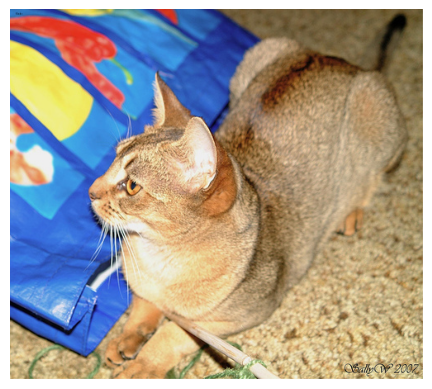

In [ ]:
# Checking if the Paths loaded correctly
plt.axis("off")
plt.imshow(load_img(input_img_paths[9]))

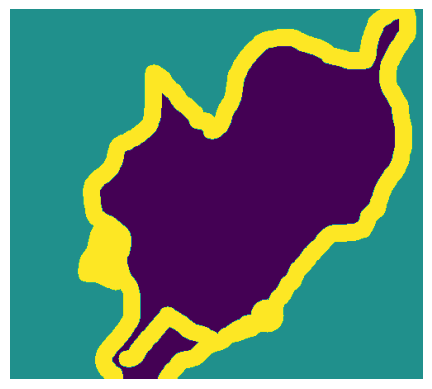

In [ ]:
# Function for Displaying Masked Image (Segmented Image)
def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127 # Normalizing the Image
    plt.axis("off")
    plt.imshow(normalized_array[:, :, 0])

img = img_to_array(load_img(target_paths[9], color_mode="grayscale")) # Loading a single image
display_target(img)

In [ ]:
# Loading entire Dataset
import cv2 as cv
from imutils import paths

img_size = (200,200)# set it as 200x200 ka tuple
num_imgs = len(input_img_paths)

random.Random(1337) # Shuffle the Paths (input_img_paths and target_paths), shuffled so that no bias??
random.shuffle(input_img_paths)
random.shuffle(target_paths)

# Create function to load input image from path
def path_to_input_image(path):
  image = load_img(path, target_size=img_size)
  return image

# Create function to load target image from path
def path_to_target(path):
    img = img_to_array(load_img(path, color_mode='grayscale', target_size=img_size))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32")
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

num_val_samples = 1000 # Play around with it if want to
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

## Model

A Image Segmentation Model, at its core, typically comprises a convolutional neural network (CNN) architecture, leveraging its ability to capture hierarchical features in an image. The model consists of encoder or Downsampler and decoder or Upsampler components, where the encoder extracts relevant features from the input image, and the decoder reconstructs the segmented output.

Each Conv2D layer in the encoder applies filters to the input image, extracting low-level to high-level features. As you move deeper into the encoder, the spatial dimensions of the feature maps typically decrease while the depth (number of channels) increases.

Conv2DTranspose layers are employed in the decoder to upsample the feature maps, gradually increasing the spatial dimensions while reducing the number of channels. Skip connections are often added between corresponding encoder and decoder layers to preserve fine-grained details.

In [ ]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(scale=1./255)(inputs)  # Add the Rescaling layer to the input

    # Encoder Block
    x = layers.Conv2D(filters = 64, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.Conv2D(filters = 64, kernel_size=3, activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(filters = 128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.Conv2D(filters = 128, kernel_size=3, activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2D(filters = 256, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.Conv2D(filters = 256, kernel_size=3, activation='relu', padding='same', strides=2)(x)

    # Decoder Block
    x = layers.Conv2DTranspose(filters = 256, kernel_size=3, activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(filters = 256, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(filters = 128, kernel_size=3, activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(filters = 128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(filters = 64, kernel_size=3, activation='relu', padding='same', strides=2)(x)
    x = layers.Conv2DTranspose(filters = 1, kernel_size=3, activation='relu', padding='same')(x)

    # # Final Output Layer
    outputs = layers.Conv2D(num_classes,3, padding ='same', activation ='softmax')(x)

    # Create the Model using the Model API
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

  # Define your image size here
num_classes = 3  # Number of classes for the segmentation tasl

model = get_model(img_size=img_size, num_classes=num_classes)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 rescaling (Rescaling)       (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 64)      36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 128)     73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 50, 50, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 50, 50, 256)       295168

In [ ]:
model.compile(optimizer='adam', loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])

 # Use appropriate Loss function (Hint: Images use kar rhe hai toh konsa use hoga?)
# Callbacks: https://keras.io/api/callbacks/
# We are saving this model after each epoch so that bichme agar band hogaya toh bhi we have somewhere to start with
callbacks = [keras.callbacks.ModelCheckpoint("oxford_segmentation.x",
                                    save_best_only=True, verbose=2)]

## Training and Testing

In [ ]:
# Train the Model for 3 epochs with the batch size of 64, make sure to set the callbacks parameter
# 3 epochs se jyda kiya toh Colab Crash hota sadly.. if you wanna do more, try kaggle pe ya locally

history = model.fit(train_input_imgs, train_targets, epochs = 3, batch_size = 64,
                    validation_data=(val_input_imgs, val_targets), callbacks=callbacks)

Epoch 1/3
100/100 [==============================] - ETA: 0s - loss: 0.9779 - accuracy: 0.5209
Epoch 1: val_loss improved from inf to 0.88871, saving model to oxford_segmentation.x
100/100 [==============================] - 158s 1s/step - loss: 0.9779 - accuracy: 0.5209 - val_loss: 0.8887 - val_accuracy: 0.5782
Epoch 2/3
100/100 [==============================] - ETA: 0s - loss: 0.8747 - accuracy: 0.5823
Epoch 2: val_loss improved from 0.88871 to 0.86697, saving model to oxford_segmentation.x
100/100 [==============================] - 86s 863ms/step - loss: 0.8747 - accuracy: 0.5823 - val_loss: 0.8670 - val_accuracy: 0.5783
Epoch 3/3
100/100 [==============================] - ETA: 0s - loss: 0.8609 - accuracy: 0.5823
Epoch 3: val_loss improved from 0.86697 to 0.85896, saving model to oxford_segmentation.x
100/100 [==============================] - 90s 899ms/step - loss: 0.8609 - accuracy: 0.5823 - val_loss: 0.8590 - val_accuracy: 0.5783


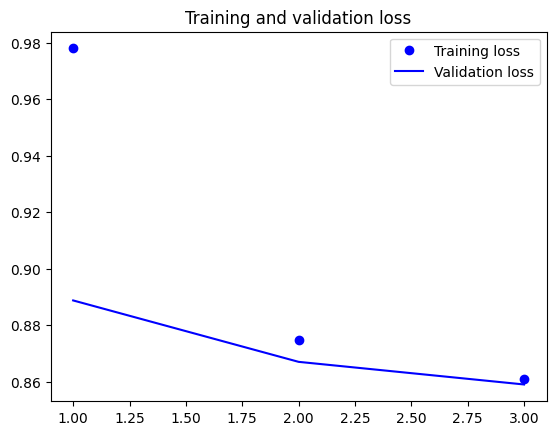

In [ ]:
# Plotting Loss
epochs = range(1, len(history.history["loss"]) + 1)
loss = history.history['loss'] # history me se Loss nikalo
val_loss = history.history['val_loss'] # history me se validation loss nikalo
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()

In [ ]:
# Load the Saved Model using load_model
model = keras.models.load_model('oxford_segmentation.x')

1/1 [==============================] - 0s 19ms/step


ValueError: num must be an integer with 1 <= num <= 16, not 17

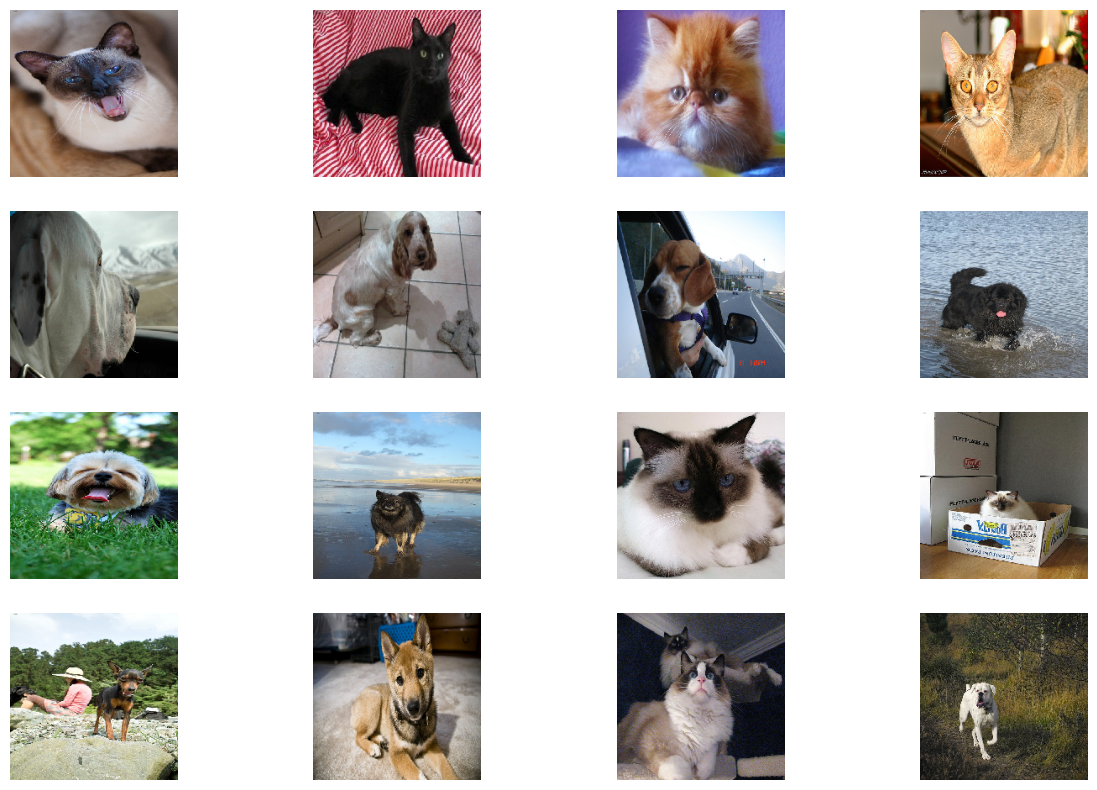

In [ ]:
def predict_and_display(images, num_images=16):
    plt.figure(figsize=(15, 10))

    for i in range(0,16,1):
        test_image = images[i]
        j = i
        plt.subplot(4, 4, j+1)
        plt.axis("off")
        plt.imshow(array_to_img(test_image))

        # Expand dimensions to match the model's expected input shape
        test_image = np.expand_dims(test_image, axis=0)
        plt.subplot(4, 4, j+2)
        # Predict and display the mask
        pred_mask = model.predict(test_image)[0]
        display_mask(pred_mask)

    plt.show()

def display_mask(pred):
    mask = np.argmax(pred, axis=-1)
    mask *= 127
    plt.axis("off")
    #plt.imshow(mask)  # Use a colormap for better visualization

# Call the function to display 20 test images
predict_and_display(val_input_imgs, num_images=20)


In [ ]:
# Garbage Collection so that aage wale parts me issue nhi aaye
del(model,train_input_imgs, train_targets, val_input_imgs, val_targets, history, input_imgs, targets)
gc.collect()

1973

## Image Segmentation using Transfer Learning and Existing Architectures

So now, we implemented a Custom Model for Image Segmentation. Abhi there are a few existing architectures which efficiently do this for us. For example: U-Net, Mask R-CNN, Fast FCN etc.

You can read more about them here:
https://neptune.ai/blog/image-segmentation#:~:text=The%20basic%20architecture%20in%20image,an%20encoder%20and%20a%20decoder.&text=The%20encoder%20extracts%20features%20from,the%20outline%20of%20the%20object.



We will now implement U-Net Architecture. It is similar to the one we created above.
https://www.geeksforgeeks.org/u-net-architecture-explained/

## Data Loading

In [19]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteG7DR51/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incompleteG7DR51/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [20]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [21]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'],(128,128)) # Use tf.image to resize datapoint["image"] to (128,128)
  input_mask = tf.image.resize(datapoint['segmentation_mask'],(128,128), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR) # Use Nearest Neighbour Method to resize datapoint["segmentation_mask"] to (128,128) for the image mask

  input_image = input_image / 255.0 # Normalize the Images
  #imput_mask = input_mask / 255.0

  return input_image, input_mask

The dataset already contains the required training and test splits, so continue to use the same splits:

In [22]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [23]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

The following class performs a simple augmentation by randomly-flipping an image.

[Image augmentation](https://www.tensorflow.org/tutorials/images/data_augmentation)


In [24]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode='horizontal', seed=seed)# Do the same for this

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

Build the input pipeline, applying the augmentation after batching the inputs:

In [25]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE)) # Prefetch is an important step towards training efficiency as it allows the Model to Fetch the Next Batch of Data while Training on a Different Batch
    # AUTOTUNE allows Tensorflow to automatically adjust the prefetch buffer. Use that.

test_batches = test_images.batch(BATCH_SIZE)

Visualize an image example and its corresponding mask from the dataset:

In [26]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

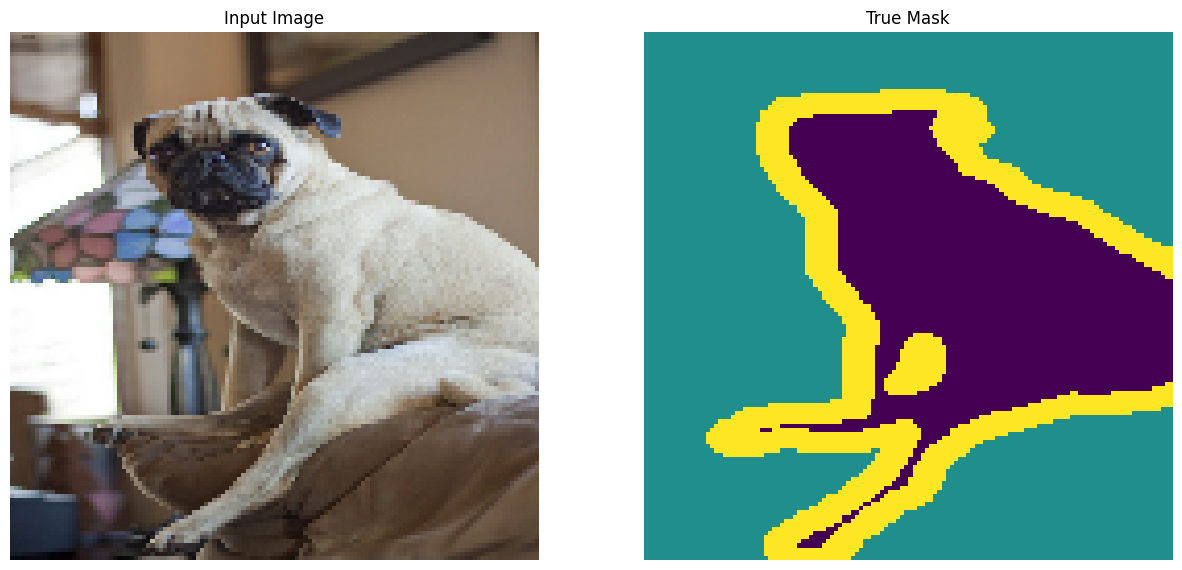

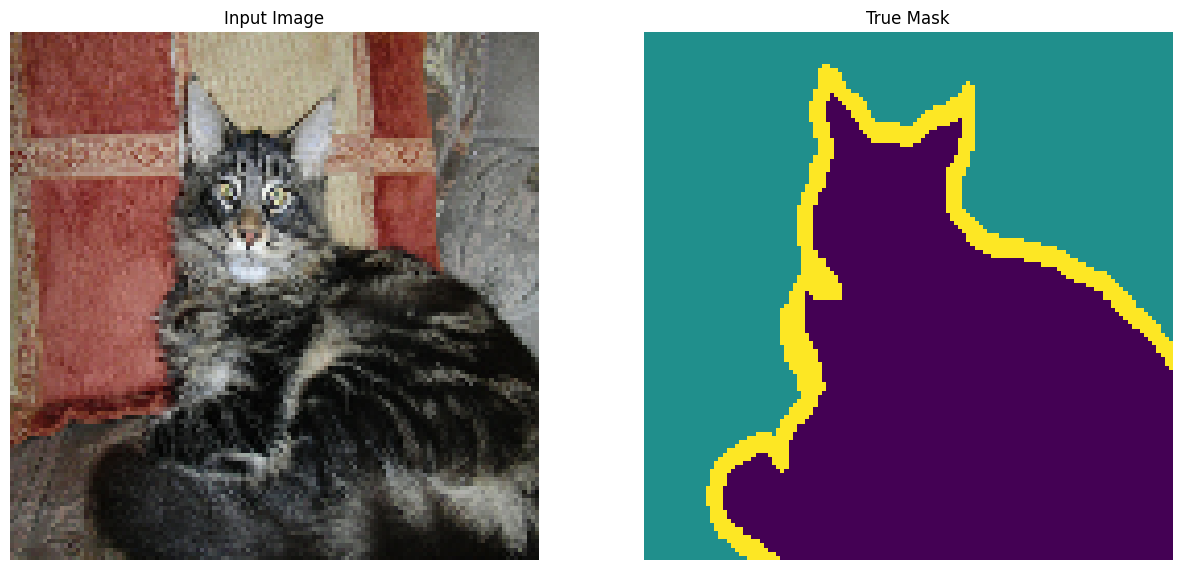

In [27]:
# Use the train_batches to obtain 2 images and display them using the function above
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display([sample_image, sample_mask])

## Define the model

The model being used here is a modified [U-Net](https://arxiv.org/abs/1505.04597). A U-Net consists of an encoder (downsampler) and decoder (upsampler). To learn robust features and reduce the number of trainable parameters, use a pretrained model—[MobileNetV2](https://arxiv.org/abs/1801.04381)—as the encoder. For the decoder, you will use the upsample block, which is already implemented in the [pix2pix](https://github.com/tensorflow/examples/blob/master/tensorflow_examples/models/pix2pix/pix2pix.py) example in the TensorFlow Examples repo.

As mentioned, the encoder is a pretrained MobileNetV2 model. You will use the model from `tf.keras.applications`. The encoder consists of specific outputs from intermediate layers in the model. Note that the encoder will not be trained during the training process.

In [4]:
from keras.applications.mobilenet_v2 import MobileNetV2

base_model = MobileNetV2(weights = 'imagenet', input_shape = (128,128,3), include_top = False)# Load the MobileNetV2 Pre-trained model without its final Dense Layers with input_shape=[128, 128, 3]

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model using the tf.keras.Model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

# Since this acts as our pre-trained encoder block, make sure to set the layers to be non-trainable
down_stack.trainable = False

9406464/9406464 [==============================] - 2s 0us/step


The decoder/upsampler is simply a series of upsample blocks implemented in TensorFlow examples:

In [5]:
# Use pix2pix upsample layers to get our unsampling block
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

In [10]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3]) # Create an Input Layer of shape (128,128,3)

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate() # Concatenate X and Skip Layers
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

Note that the number of filters on the last layer is set to the number of `output_channels`. This will be one output channel per class.

## Train the model

Now, all that is left to do is to compile and train the model.

When running inference, the label assigned to the pixel is the channel with the highest value. This is what the `create_mask` function is doing.

In [11]:
OUTPUT_CLASSES = 3

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

Plot the resulting model architecture:

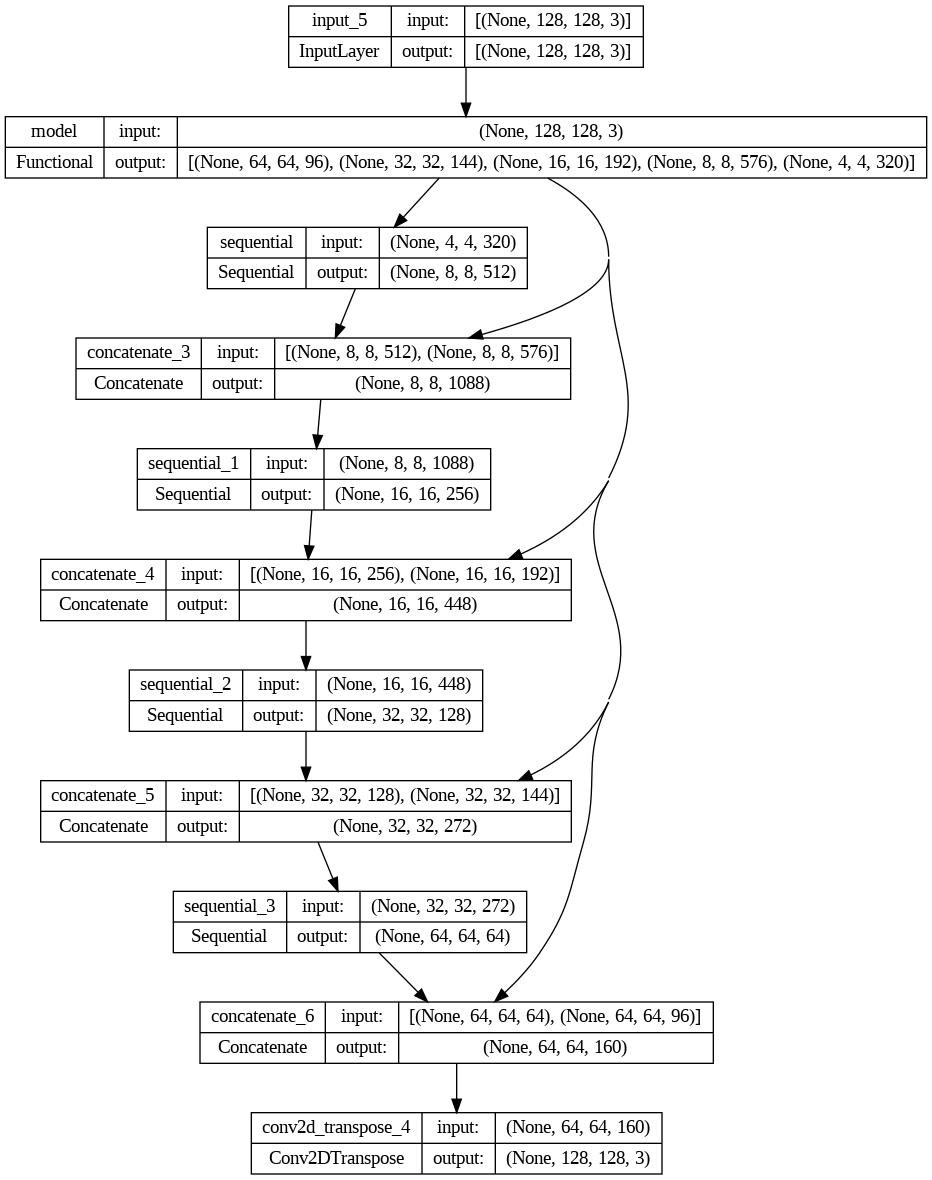

In [12]:
tf.keras.utils.plot_model(model, show_shapes=True)

Try out the model to check what it predicts before training:

In [13]:
def create_mask(pred_mask):
  pred_mask = tf.math.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [28]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

1/1 [==============================] - 4s 4s/step


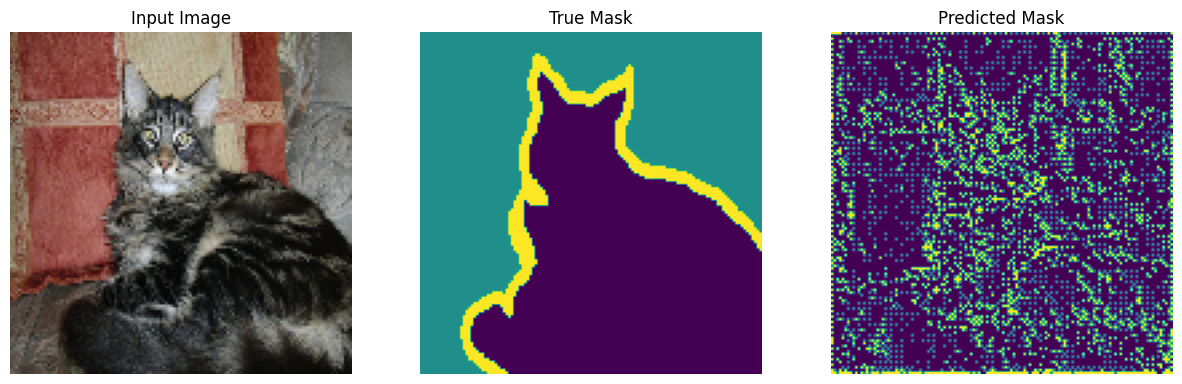

In [29]:
show_predictions()

The callback defined below is used to observe how the model improves while it is training:

In [30]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In the interest of saving time, the number of epochs was kept small, but you may set this higher to achieve more accurate results.

1/1 [==============================] - 0s 23ms/step


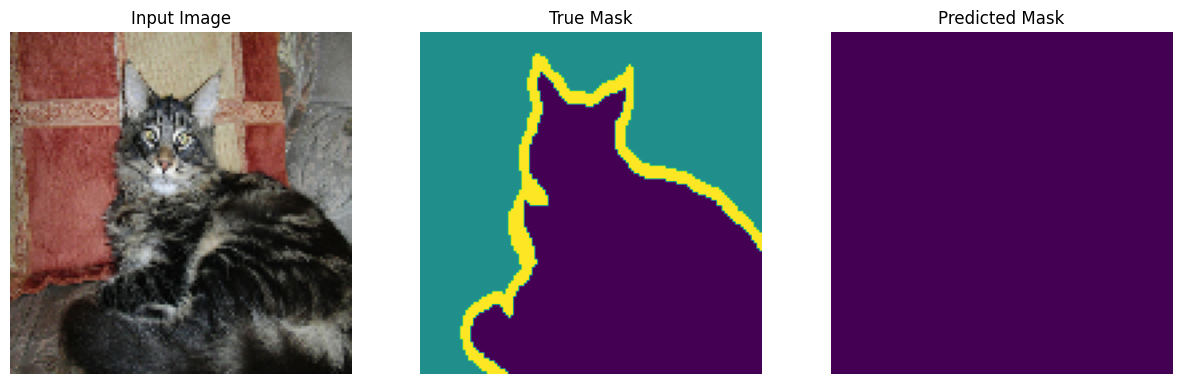


Sample Prediction after epoch 20

57/57 [==============================] - 10s 170ms/step - loss: nan - accuracy: 0.0000e+00 - val_loss: nan - val_accuracy: 0.0000e+00


In [31]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

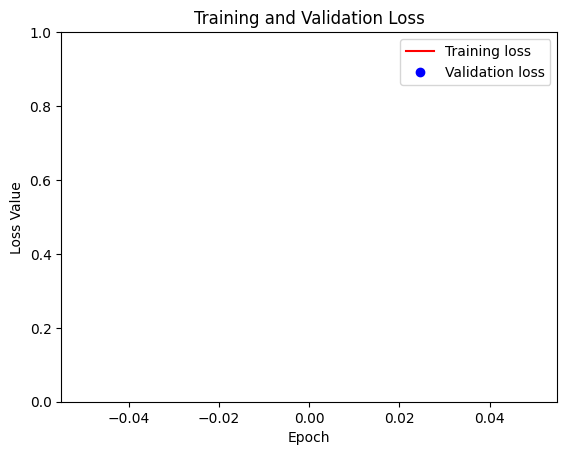

In [32]:
# Plot Loss and Validation Loss as previously done

loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

## Make predictions

Now, make some predictions.

2/2 [==============================] - 0s 45ms/step


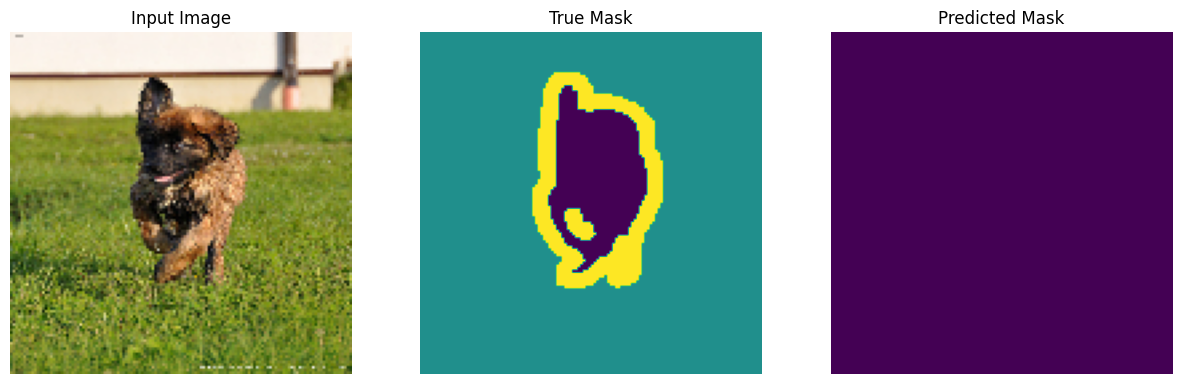

2/2 [==============================] - 0s 42ms/step


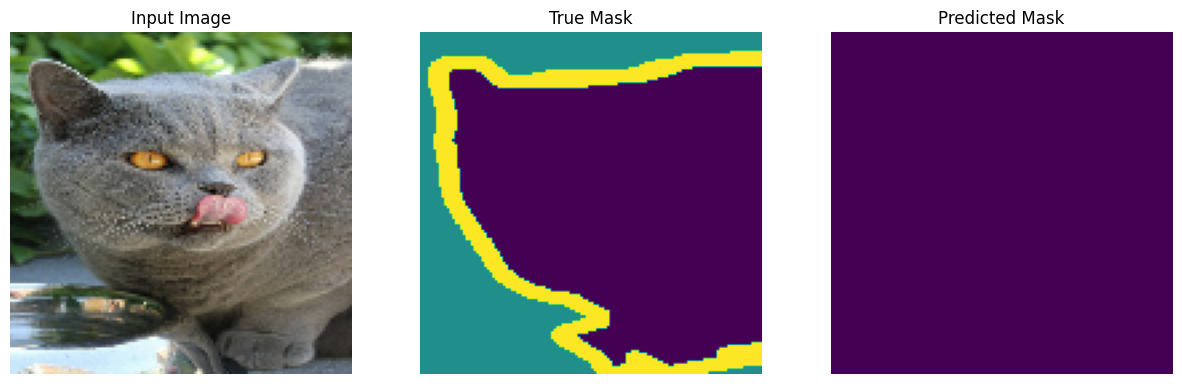

2/2 [==============================] - 0s 40ms/step


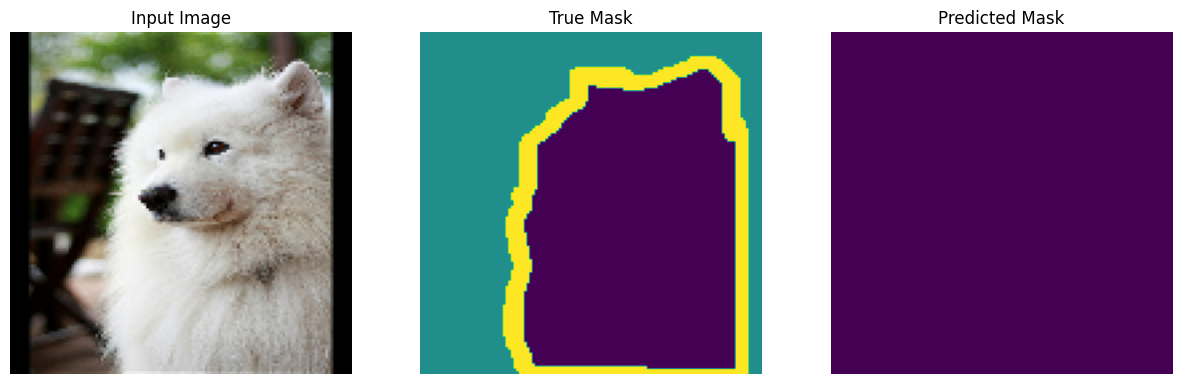

In [33]:
show_predictions(test_batches, 3)

## OPTIONAL: Image Segmentation usually involves high class imbalance. Figure out how you can reduce this problem.

# Object Detection

Object detection is a computer vision technique for locating instances of objects in images or videos.

Read more:

https://www.mathworks.com/discovery/object-detection.html

https://www.analyticsvidhya.com/blog/2022/03/a-basic-introduction-to-object-detection/

In this, we will not use one of those high performing off-the-shelf object detectors but develop a new one ourselves, from scratch, using plain python, OpenCV, and Tensorflow.

An Object Detection is a combination of two tasks:
*   Regression of the bound-box coordinates
*   Classification of the object label

This means that our model has two outputs: namely the object label and the object bound box. Therefore, the model must combine the tasks of classification and regression.

The Dataset we will be using is:

https://www.kaggle.com/datasets/techzizou/labeled-mask-dataset-yolo-darknet

Drive pe daaldena

## Imports

In [ ]:
import os, random
from google.colab import drive
import tensorflow as tf
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Data Loading

This code basically generates three lists: one for training (holding 70% of the data), one for validation (20% of the data) and one for test (the last 10%). The code also shuffle the data in order to avoid any natural bias.

Note that we are removing the images with more than one masks/objects. This is because we are building a simple object detector able to detect only a single object in an image.

In [ ]:
def list_files(full_data_path = "/content/gdrive/My Drive/CV2 Task/obj/", image_ext = '.jpg', split_percentage = [70, 20]):

    files = []

    discarded = 0
    masked_instance = 0

    for r, d, f in os.walk(full_data_path):
        for file in f:
            if file.endswith(".txt"):

                # first, let's check if there is only one object
                with open(full_data_path + "/" + file, 'r') as fp:
                    lines = fp.readlines()
                    if len(lines) > 1:
                        discarded += 1
                        continue


                strip = file[0:len(file) - len(".txt")]
                # secondly, check if the paired image actually exist
                image_path = full_data_path + "/" + strip + image_ext
                if os.path.isfile(image_path):
                    # checking the class. '0' means masked, '1' for unmasked
                    if lines[0][0] == '0':
                        masked_instance += 1
                    files.append(strip)

    size = len(files)
    print(str(discarded) + " file(s) discarded")
    print(str(size) + " valid case(s)")
    print(str(masked_instance) + " are masked cases")

    random.shuffle(files)

    split_training = int(split_percentage[0] * size / 100)
    split_validation = split_training + int(split_percentage[1] * size / 100)

    return files[0:split_training], files[split_training:split_validation], files[split_validation:]

training_files, validation_files, test_files = list_files()

218 file(s) discarded
1292 valid case(s)
832 are masked cases


In [ ]:
print(str(len(training_files)) + " training files")
print(str(len(validation_files)) + " validation files")
print(str(len(test_files)) + " test files")

904 training files
258 validation files
130 test files


Since our model will be using a fixed 244 x 244 input layer, we need to format any input image before feed it to the model (to train or to predict).

In [ ]:
input_size = 244

def format_image(img, box):
  '''
  1. Get the height and width of the input image.
  2. Calculate the maximum dimension of the image (either height or width).
  3. Calculate the scaling ratio needed to fit the image within the desired input_size.
  4. Calculate the new width and height of the image based on the scaling ratio.
  5. Create a tuple new_size containing the new width and height.
  6. Resize the original image to the new dimensions using linear interpolation.
  7. Create a new image (new_image) of size input_size x input_size initialized with zeros.
  8. Place the resized image in the upper-left corner of new_image, filling the remaining space with zeros.
  '''

  x, y, w, h = box[0], box[1], box[2], box[3]

  # Calculate the new coordinates and dimensions (new_box) based on the scaling ratio (r)
  new_box

  return new_image, new_box

In [ ]:
def data_load(files, full_data_path = "/content/gdrive/My Drive/CV2 Task/obj/", image_ext = ".jpg"):
    X = []
    Y = []

    for file in files:
        img = cv.imread(os.path.join(full_data_path, file + image_ext), cv.IMREAD_GRAYSCALE)

        k = 1

        with open(full_data_path + "/" + file + ".txt", 'r') as fp:
            line = fp.readlines()[0]
            if line[0] == '0':
                k = 0

            box = np.array(line[1:].split(), dtype=float)

        img, box = format_image(img, box)
        img = img.astype(float) / 255.
        box = np.asarray(box, dtype=float) / input_size
        label = np.append(box, k)

        X.append(img)
        Y.append(label)

    X = np.array(X)

    X = np.expand_dims(X, axis=3)

    X  # Convert X and Y to tensors with dtype as float32

    Y

    result = tf.data.Dataset.from_tensor_slices((X, Y))

    return result

In [ ]:
raw_train_ds = data_load(training_files)

In [ ]:
raw_validation_ds = data_load(validation_files)

In [ ]:
raw_test_ds = data_load(test_files)

Since our model must implement two tasks — classification and regression — we need two different Loss Functions:

* One for the classification task: we may use any Loss Function usually found in only-classification tasks like Categorical Crossentropy.
* One for the bound box regression: we can use a regression Loss Function such as Mean Squared Error.



In [ ]:
CLASSES = 2

def format_instance(image, label):
    return image, (tf.one_hot(int(label[4]), CLASSES), [label[0], label[1], label[2], label[3]])

In [ ]:
BATCH_SIZE = 32

# see https://www.tensorflow.org/guide/data_performance

def tune_training_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.repeat() # The dataset be repeated indefinitely.
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
train_ds = tune_training_ds(raw_train_ds)

In [ ]:
def tune_validation_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(len(validation_files) // 4)
    dataset = dataset.repeat()
    return dataset

In [ ]:
validation_ds = tune_validation_ds(raw_validation_ds)

In [ ]:
def tune_test_ds(dataset):
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(1)
    dataset = dataset.repeat()
    return dataset

test_ds = tune_test_ds(raw_test_ds)

## Model

In [ ]:
def build_feature_extractor(inputs):
    # use 3 pairs of Conv2D and AveragePooling2D with relu activation and kernel size = 3. Keep in mind we will be using

    return x

def build_model_adaptor(inputs):
    # Use one Flatten and One Dense Relu Layer
    return x

def build_classifier_head(inputs):
    # use a Softmax Layer named classifier_head
    return

def build_regressor_head(inputs):
    # use a Dense layer with 4 units named regressor_head
    return

def build_model(inputs):

    feature_extractor = build_feature_extractor(inputs)

    model_adaptor = build_model_adaptor(feature_extractor)

    classification_head = build_classifier_head(model_adaptor)

    regressor_head = build_regressor_head(model_adaptor)

    model = tf.keras.Model(inputs = inputs, outputs = [classification_head, regressor_head])

    return model

Now that we have everything, Let's start with training!

## Training

In [ ]:
model = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 1,)))

model.compile()# Use Adam and set loss and metric for classifier_head and regressor_head as stated earlier

In [ ]:
# Plot the Model

In [ ]:
EPOCHS = 100
BATCH_SIZE = 32

history = model.fit(train_ds,
                    steps_per_epoch=(len(training_files) // BATCH_SIZE),
                    validation_data=validation_ds, validation_steps=1,
                    epochs=EPOCHS)

## IoU Metric

IoU scores how well the predicted bound box overlaps the actual bound box. The idea behind IoU is pretty simple: compare the intersection and union areas between the predicted and actual bound boxes by dividing the intersection by the union. IoU provides a higher score always when the predicted bounding box best matches the actual bounding box (also called ground-truth)

In [ ]:
def intersection_over_union(boxA, boxB):
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
	yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
	interArea = # Calculate Intersection Area
	boxAArea = # Calcualate BoxA Area
	boxBArea = # Calculate BoxB Area
	iou = # Find IOU
	return iou

## Prediction

In [ ]:
plt.figure(figsize=(12, 10))

test_list = list(test_ds.take(20).as_numpy_iterator())

image, labels = test_list[0]

for i in range(len(test_list)):

    ax = plt.subplot(4, 5, i + 1)
    image, labels = test_list[i]

    predictions = model(image)

    predicted_box = predictions[1][0] * input_size
    predicted_box = tf.cast(predicted_box, tf.int32)

    predicted_label = predictions[0][0]

    image = image[0]

    actual_label = labels[0][0]
    actual_box = labels[1][0] * input_size
    actual_box = tf.cast(actual_box, tf.int32)

    image = image.astype("float") * 255.0
    image = image.astype(np.uint8)
    image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

    color = (255, 0, 0)
    # print box red if predicted and actual label do not match
    if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[0] < 0.5 and actual_label[0] == 0):
        color = (0, 255, 0)

    img_label = "unmasked"
    if predicted_label[0] > 0.5:
        img_label = "masked"

    predicted_box_n = predicted_box.numpy()
    cv.rectangle(image_color, predicted_box_n, color, 2)
    cv.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 2)
    cv.rectangle(image_color, (predicted_box_n[0], predicted_box_n[1] + predicted_box_n[3] - 20), (predicted_box_n[0] + predicted_box_n[2], predicted_box_n[1] + predicted_box_n[3]), color, -1)
    cv.putText(image_color, img_label, (predicted_box_n[0] + 5, predicted_box_n[1] + predicted_box_n[3] - 5), cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0))

    IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())

    plt.title("IoU:" + format(IoU, '.4f'))
    plt.imshow(image_color)
    plt.axis("off")

# RESEARCH WORK:
Find out about Common Problems in Segmentation and Object Detection and the Solution for the same. Also Find how these Models can be used for Image Generation within GANs and VAEs.